In [1]:
# All Imports

import astra
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc



import numpy as np
#import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import SGD, RMSprop
import random
#from scipy.misc import imresize
import keras.backend as K
import copy


# GAN model

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
#from scipy.misc import imsave
import scipy.stats
from skimage.measure import compare_ssim as ssim
import pydicom
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage import exposure
import glob
#from scipy.misc import imread
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_psnr
import numpy
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii

Using TensorFlow backend.
/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
# [STAR] All the paths for training the model

projectionpath        = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'
highprojectionpath    = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'
savepath              = '/media/pranjal/newdrive1/DBT-PROJ-DENOISE/'


modelname = "normal-to-three-0.99"

In [3]:
# [STAR] Helper functions for training the de-noising CNN

def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def get_crop_image(lowimg, highimg):
    factor = 1
    
    #slice_index = random.randint(0, 24)
    #lowimg  = lowimg[slice_index]
    #highimg = highimg[slice_index]

    thresh  = threshold_otsu(lowimg)
    binary  = lowimg < thresh
    result  = np.multiply(binary, lowimg)

    rmin, rmax, cmin, cmax = bbox2(result)
    resultlowimg = result[rmin:rmax, cmin:cmax]
    resultlowimg = resultlowimg.astype(float)

    result        = np.multiply(binary, highimg)
    resulthighimg = result[rmin:rmax, cmin:cmax]
    resulthighimg = resulthighimg.astype(float)
    
    return resultlowimg, resulthighimg
    
def get_train_data_proj(lowimg, highimg, epoch, batch_size):
    highdose = []
    lowdose  = []
    cliplimit = 0
    
    imgshape = 256
    
    
    # loop till samples of size batch_size with atleast 90% occupancy is not obtained
    crop_count = 0
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    while(crop_count < batch_size):
        cropimgx = random.randint(1, rowst-imgshape)
        cropimgy = random.randint(1, colst-imgshape)
        
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov = np.sum(lowimg_crop > cliplimit)
        # atleast 90% occupancy should be there
        if nonzerov*1.0/(imgshape*imgshape) < 0.65:
            continue
        
        highimg_crop = highimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        #prob = random.randint(0, 100)
        #if prob < 50:
        #    lowimg_crop  = np.fliplr(lowimg_crop)
        #    highimg_crop = np.fliplr(highimg_crop)
        
        #lowimg_crop_mean  = np.mean(lowimg_crop.flatten())
        #highimg_crop_mean = np.mean(highimg_crop.flatten())
        #diff_mean         = highimg_crop_mean -  lowimg_crop_mean
        
        lowdose.append(lowimg_crop)
        highdose.append(highimg_crop)
        
        crop_count = crop_count+1
        
    return np.array(lowdose), np.array(highdose)

def mse(x, y):
    return np.linalg.norm(x - y)

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 200
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    
    cleanimage = np.zeros(limg.shape)
    
    thresh      = threshold_otsu(limg)
    binarymax   = limg > thresh
    
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    restimage   = binarymax#np.multiply(binarymax, limg)
    minvalue    = np.min(limg)
    
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    
    newbinary    = np.multiply(binary, binary1)
    result       = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/(thresh/2)
    lowimg       = resultlowimg-1
    
    #print(np.max(lowimg), np.mean(lowimg), np.min(lowimg), thresh)
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    halfvalue    = int(imgshape/2)
    quartervalue = int(imgshape/4)#+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(imgshape*imgshape) < 0.5:
#                 cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = tempimg[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
#                 j = j+halfvalue
#                 continue
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            cleanimg    = cleanimg - (after_mean-before_mean)
            
            #print(np.mean(tempimg), np.mean(cleanimg))
            
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = cleanimg[0, :, :, 0][quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
            j = j+halfvalue
        i = i+halfvalue
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage+1
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    #print(np.max(img_adapteq), np.mean(img_adapteq), np.min(img_adapteq), thresh)
    
    mul_result   = img_adapteq*(thresh/2)
    mul_result   = mul_result+minvalue
    
    #print('restimage max  ', np.max(restimage))
    #print('mul_result max ', np.max(mul_result))
    
    tempvalue = np.min(mul_result)
    #restimage = restimage*np.max(mul_result)
    
    #mul_result   = mul_result + restimage
    #mul_result   = mul_result - tempvalue
    
    #print(mul_result.shape, restimage.shape)
    
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    #print(np.max(mul_result), np.mean(mul_result), np.min(mul_result))
    #print(np.mean(pt2), np.max(pt2), np.min(pt2))
    mul_result   = mul_result.astype(np.uint16)
    #print(np.mean(mul_result), np.max(mul_result), np.min(mul_result))
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    
def test_on_whole_proj(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0.
    
    ds     = pydicom.dcmread(lowfilename)
    limg   = ds.pixel_array
    
    cleanimage = np.zeros(limg.shape)
    
    # get the histogram equalized image
    thresh      = threshold_otsu(limg)
    value_range = thresh - np.min(limg)
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    newbinary = np.multiply(binary, binary1)
    result    = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/thresh
    resultlowimg = exposure.equalize_adapthist(resultlowimg, clip_limit=cliplimit)
    lowimg       = resultlowimg
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    
    # For bottom row
    i = rowst-128
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    # For rightmost column
    j = colst-128
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # For leftmost column
    j = 0
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+128 < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            nonzerov     = np.sum(lowimg_crop >= cliplimit)
            
            # If it is not mostly occupied then don't process it
            if nonzerov*1.0/(128*128) < 0.9:
                cleanimage[i+64:i+128, j+64:j+128] = tempimg[32:96, 32:96]
                j = j+64
                continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            cleanimage[i+64:i+128, j+64:j+128] = cleanimg[0, :, :, 0][32:96, 32:96]
            j = j+64
        i = i+64
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    
    print('value range is ', value_range)
    mul_result   = img_adapteq*value_range
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    mul_result   = mul_result.astype(np.uint16)
    
    
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    max_value = np.max(mul_result)
    mul_result[mul_result == 0] = max_value*2
    
    #plt.hist(mul_result.flatten(), bins=256, range=(np.min(mul_result)+0.01, np.max(mul_result)), fc='k', ec='k')
    #plt.show()
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)

def test_on_whole_slice(lowfilename, highfilename, model, xindex, jindex):
    highdose = []
    lowdose  = []
    cliplimit = 0.03
    
    #projindex    = str(slicenum).zfill(2)+'.dcm'
    #lowfilename  = projectionpath+str(filenum)+'_20/_'+projindex
    #highfilename = highprojectionpath+str(filenum)+'_100/_'+projindex
    
    ds     = pydicom.dcmread(lowfilename)
    lowimg = ds.pixel_array
    
    ds      = pydicom.dcmread(highfilename)
    highimg = ds.pixel_array
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg, cliplimit)
    
    totalimage      = []
    totalimagereal  = []
    totalimagerealh = []
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    print('Shape of Image is ', rowst, 'x', colst)
    
    # Change the indexing later to accomodate the full image view
    # Or second option is to do the averaging at the corner views
    
    # count of processed rows in the whole image
    processed_count_total = 0
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    
    while(i+128 < rowst):
        # for clean image from model
        newrow      = []
        # for the real lowdose image
        newrowreal  = []
        # for the real highdose image
        newrowrealh = []
        # count of images processed in a row
        processed_count_row = 0
        # re-initialize the counter for j
        j = 0
        
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            tempimgh = highimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            newrowreal.append(tempimg[32:96, 32:96])
            newrowrealh.append(tempimgh[32:96, 32:96])
            
#             nonzerov = np.sum(lowimg_crop >= cliplimit)
#             # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(128*128) < 0.9:
#                 newrow.append(tempimg[32:96, 32:96])
#                 processed_count_row = processed_count_row+1
#                 continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            newrow.append(cleanimg[0, :, :, 0][32:96, 32:96])
            processed_count_row = processed_count_row+1
            
            if i  == (128*xindex) and j == (128*jindex):
                print('Clean Image SNR',    np.mean(cleanimg[0, :, :, 0])/np.std(cleanimg[0, :, :, 0]))
                print('Original Image SNR', np.mean(tempimg)/np.std(tempimg))
                print('HIGH Original Image SNR', np.mean(tempimgh)/np.std(tempimgh))
                
                ssim_low   = ssim(tempimgh, tempimg, data_range=tempimg.max() - tempimg.min())
                ssim_clean = ssim(tempimgh, cleanimg[0, :, :, 0], data_range=cleanimg[0, :, :, 0].max() - cleanimg[0, :, :, 0].min())
                
                print('SSIM low ',   ssim_low)
                print('SSIM clean ', ssim_clean)
                
                mse_clean   = mse(tempimgh, cleanimg[0, :, :, 0])
                mse_low     = mse(tempimgh, tempimg)
                
                print('MSE low ',   mse_low)
                print('MSE clean ', mse_clean)
                
                imsave('testimage.jpg', tempimg)
                imsave('clean2.jpg', cleanimg[0, :, :, 0])
                imsave('low2.jpg',   tempimg)
                imsave('high2.jpg',  tempimgh)
            j = j+64
        i = i+64
                
        combined = np.array(newrow)
        #print('newrow length is ', len(newrow), combined.shape)
        
        combined = np.hstack(combined.reshape(processed_count_row, 64, 64))
        totalimage.append(combined)
        
        combinedreal = np.array(newrowreal)
        combinedreal = np.hstack(combinedreal.reshape(processed_count_row, 64, 64))
        totalimagereal.append(combinedreal)
        
        combinedrealh = np.array(newrowrealh)
        combinedrealh = np.hstack(combinedrealh.reshape(processed_count_row, 64, 64))
        totalimagerealh.append(combinedrealh)
        
        # increment the rows processed count
        processed_count_total = processed_count_total+1
        
        #print('Shape of the combined image is ', combined.shape)
    
    totalimage = np.array(totalimage)
    totalimage = np.vstack(totalimage.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagereal = np.array(totalimagereal)
    totalimagereal = np.vstack(totalimagereal.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagerealh = np.array(totalimagerealh)
    totalimagerealh = np.vstack(totalimagerealh.reshape(processed_count_total, 64, processed_count_row*64))
    
    return totalimage, totalimagereal, totalimagerealh

image_indexes_result      = []
temp_image_indexes_result = []

def store_results(epoch, saveseed=5):
    global image_indexes_result
    global temp_image_indexes_result
    
    imgshape = 256
    
    # set the ids for saving the results
    random.seed(saveseed)
    
    projindex    = 55
    lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    
    lowimg  = np.fromfile(lowfilename, dtype='float32')
    highimg = np.fromfile(highfilename, dtype='float32')
    lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
    highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
    
    slice_index = 12#random.randint(0, 24)
    lowimg      = lowvol[slice_index]
    highimg     = highvol[slice_index]
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg)
    
    r, c = 6, 6
    x, y = get_train_data_proj(lowimg, highimg, 1, 128)
    x = x-0.5
    y = y-0.5
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95)
    plt.tight_layout()
    fig, axs = plt.subplots(r, c, figsize=(30,10))
    cnt      = 0
    
    for i in range(r):
        for j in range(c):
            if len(image_indexes_result) == 0:
                imgindex = random.randint(1, 127)
                temp_image_indexes_result.append(imgindex)
            else:
                imgindex = image_indexes_result[cnt]
            
            cleanimg = aae.generator.predict(np.expand_dims([x[imgindex]], axis=3))
            combined = np.array([x[imgindex]+0.5, cleanimg[0, :, :, 0]+0.5, y[imgindex]+0.5])
            combined = np.hstack(combined.reshape(3,imgshape,imgshape))
            #print(cleanimg[0, :, :, 0].shape, y[imgindex].shape, combined.shape)
            axs[i,j].imshow(combined, cmap='gray')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i,j].axis('off')
            cnt += 1
    if len(image_indexes_result) == 0:
        image_indexes_result = temp_image_indexes_result
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig(savepath+modelname+"-results/clean_%d.png" % epoch, bbox_inches='tight')
    plt.close()

In [8]:
# [STAR] Model for training the de-noising network

img_shape  = (256, 256, 1)

class AdversarialAutoencoder():
    def __init__(self):
        self.optimizer1  = RMSprop(0.0005)
        self.optimizer2  = RMSprop(0.00001)
        
        self.clip_value = 0.01
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/vanilla-gan-weights-mse-0.1/discriminator_weights_8050.h5')
        self.d_arr = []
        self.g_arr = []
        
        # Build the encoder / decoder
        self.generator = self.build_generator()
         
        img = Input(shape=img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        reconstructed_img            = self.generator(img)
        #self.adversarial_autoencoder = Model(img, reconstructed_img)
        #self.adversarial_autoencoder.compile()
        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator determines validity of the cleaned image
        validity = self.discriminator(reconstructed_img)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'mse'],
            loss_weights=[0.99, 0.01],
            optimizer=self.optimizer2)
        
        self.discriminator.trainable = True
        self.discriminator.compile(loss='mse',
            optimizer=self.optimizer1, 
            metrics=['accuracy'])
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/discriminator_weights_8400.h5')
        #self.generator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/generator_weights_8400.h5')

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_autoencoder(self):
        self.generator.compile(loss=['mse'],optimizer=self.optimizer)
     
    def build_generator(self):
        x = Input(shape=img_shape)
        x1 = Conv2D(32, (3, 3), padding='same')(x)
        x1 = LeakyReLU(alpha=0.2)(x1)
        
        x2 = Conv2D(64, (3, 3), padding='same')(x1)
        #x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        
        x3 = Conv2D(64, (3, 3), padding='same')(x2)
        #x3 = BatchNormalization(momentum=0.8)(x3)
        x3 = LeakyReLU(alpha=0.2)(x3)
        
        #x3_m = merge([x2, x3], mode='concat', concat_axis=3)
        x4 = Conv2D(64, (3, 3), padding='same')(x3)
        #x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2)(x4)
        #x6_i = merge([x2, x6], mode='concat', concat_axis=3)
        
        
        x5 = Conv2D(128, (3, 3), padding='same')(x4)\
        #x5 = BatchNormalization(momentum=0.8)(x5)
        x5 = LeakyReLU(alpha=0.2)(x5)
        
        #x7_i = merge([x1, x7], mode='concat', concat_axis=3)
        x6 = Conv2D(128, (3, 3), padding='same')(x5)
        x6 = LeakyReLU(alpha=0.2)(x6)
        
        x7 = Conv2D(64, (3, 3), padding='same')(x6)
        #x8 = BatchNormalization(momentum=0.8)(x8)
        x7 = LeakyReLU(alpha=0.2)(x7)
        #x7_m = merge([x1, x6], mode='concat', concat_axis=3)
        #x8    = Conv2D(1, (3, 3), activation='relu', padding='same')(x6)
        x8 = Conv2D(1, (3, 3), padding='same')(x7)
        x8 = LeakyReLU(alpha=0.2)(x8)
        
        out = keras.layers.Subtract()([x, x8])
        #out = ReLU()(out)
        model = Model(x, out)
        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        #         model.add(Conv2D(16, (6, 6),  strides=(2, 2)))
        #         model.add(LeakyReLU(alpha=0.2))
        #         model.add(Dropout(0.5))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Dense(1))
        return model
    
    def train_generator_autoencoder(self, epochs, batch_size=128):
        for epoch in range(epochs):
            # Load the dataset
            X_train, Y_train = get_train_data(epoch, batch_size)
            
            X_train = np.expand_dims(X_train, axis=3)
            Y_train = np.expand_dims(Y_train, axis=3)
            
            g_loss = self.generator.train_on_batch(X_train, Y_train)
            
            # Plot the progress
            print ("Epoch ", epoch, " G loss ", g_loss)
            if epoch%50 == 0:
                store_results(epoch)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
    
    def train(self, epochs, batch_size=128, sampling=50, saveseed=5, startepoch=0, discriminator_epochs=5):
        for epoch in range(startepoch, epochs):
            # Train the discriminator 5 times
            #print('Training Discriminator ', epoch)
            
            projindex = str(random.randint(43, 68))#+'.dcm'
    
            lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
            highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

            lowimg  = np.fromfile(lowfilename, dtype='float32')
            highimg = np.fromfile(highfilename, dtype='float32')
            
            lowvol  = np.reshape(lowimg,  [25, 1600, 3200])/1250.0
            highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
            
            for itd in range(discriminator_epochs):
                slice_index = random.randint(0, 24)
                lowimg      = lowvol[slice_index]
                highimg     = highvol[slice_index]
                
                # get the cropped image
                lowimg, highimg =  get_crop_image(lowimg, highimg)
                
                # Load the dataset
                X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
                X_train = X_train - 0.5
                Y_train = Y_train - 0.5
                
                #print(X_train.shape, Y_train.shape)
                
                X_train = np.expand_dims(X_train, axis=3)
                Y_train = np.expand_dims(Y_train, axis=3)

                # Adversarial ground truths
                valid = np.ones((batch_size, 1))
                fake  = np.zeros((batch_size, 1))

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # get the noisy image and feed it into the generator
                X_train_clean = self.generator.predict(X_train)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(Y_train, valid)
                d_loss_fake = self.discriminator.train_on_batch(X_train_clean, fake)
                d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #print('Training Generator ', epoch)
            # ---------------------
            #  Train Generator
            # ---------------------
            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(X_train, [Y_train, valid])
            #print('g_loss ', g_loss)
            self.d_arr.append(d_loss)
            self.g_arr.append(g_loss)
            
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' D loss real ', -d_loss_real, ' D loss fake ', d_loss_fake, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            # Plot the progress
            #print ("%d [D loss: %f] [G loss: %f] [G loss: %f %f]" % (epoch, 1 - d_loss, 1 - g_loss[0], g_loss[0], g_loss[1]))
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            
            if epoch%sampling == 0:
                store_results(epoch, saveseed)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                #self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
            
            print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[2]*0.0001, g_loss[1]*0.999))

In [9]:
# [STAR] Training loop of the model

aae = AdversarialAutoencoder()
# print(aae.generator.summary())
# print(aae.discriminator.summary())

In [6]:
projindex = str(random.randint(43, 68))#+'.dcm'
epoch = 0
batch_size = 32

lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

lowimg  = np.fromfile(lowfilename, dtype='float32')
highimg = np.fromfile(highfilename, dtype='float32')

lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0


slice_index = random.randint(0, 24)
lowimg      = lowvol[slice_index]
highimg     = highvol[slice_index]

# get the cropped image
lowimg, highimg =  get_crop_image(lowimg, highimg)

# Load the dataset
X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
X_train  = X_train  - 0.5
Y_train  = Y_train  - 0.5


print(X_train.shape, Y_train.shape)

(32, 256, 256) (32, 256, 256)


In [10]:
aae.train(epochs=25000, batch_size=32, sampling=50, saveseed=7590, startepoch=0)

/home/pranjal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.444301, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000077, mse: 0.000223]
1 [D loss: 0.390462, mean_acc: 12.50% real_acc: 0.00% fake_acc: 25.00%] [G loss: 0.000076, mse: 0.000166]
2 [D loss: 0.381160, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000061, mse: 0.000358]
3 [D loss: 0.378466, mean_acc: 18.75% real_acc: 0.00% fake_acc: 37.50%] [G loss: 0.000046, mse: 0.000287]
4 [D loss: 0.379963, mean_acc: 12.50% real_acc: 0.00% fake_acc: 25.00%] [G loss: 0.000049, mse: 0.000296]
5 [D loss: 0.431028, mean_acc: 7.81% real_acc: 0.00% fake_acc: 15.62%] [G loss: 0.000055, mse: 0.000282]
6 [D loss: 0.433081, mean_acc: 14.06% real_acc: 0.00% fake_acc: 28.12%] [G loss: 0.000057, mse: 0.000182]
7 [D loss: 0.410549, mean_acc: 26.56% real_acc: 0.00% fake_acc: 53.12%] [G loss: 0.000055, mse: 0.000244]
8 [D loss: 0.399771, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000060, mse: 0.000295]
9 [D loss: 0.387525, mean_acc: 29.69% real_ac

78 [D loss: 0.291862, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000018, mse: 0.000285]
79 [D loss: 0.273255, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000195]
80 [D loss: 0.273364, mean_acc: 9.38% real_acc: 18.75% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000209]
81 [D loss: 0.274845, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000233]
82 [D loss: 0.278672, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000203]
83 [D loss: 0.283085, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000148]
84 [D loss: 0.286490, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000263]
85 [D loss: 0.299296, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000145]
86 [D loss: 0.296127, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000191]
87 [D loss: 0.291725, mean_acc: 0.00% real_acc: 

155 [D loss: 0.281729, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000226]
156 [D loss: 0.281562, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000172]
157 [D loss: 0.285605, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000236]
158 [D loss: 0.287943, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000285]
159 [D loss: 0.289296, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000346]
160 [D loss: 0.295496, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000034, mse: 0.000264]
161 [D loss: 0.288916, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000289]
162 [D loss: 0.285384, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000363]
163 [D loss: 0.319919, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000081, mse: 0.000210]
164 [D loss: 0.288058, mean_acc: 0.00% real

232 [D loss: 0.283499, mean_acc: 35.94% real_acc: 0.00% fake_acc: 71.88%] [G loss: 0.000032, mse: 0.000200]
233 [D loss: 0.308863, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000038, mse: 0.000145]
234 [D loss: 0.280302, mean_acc: 20.31% real_acc: 0.00% fake_acc: 40.62%] [G loss: 0.000031, mse: 0.000254]
235 [D loss: 7.311741, mean_acc: 28.12% real_acc: 56.25% fake_acc: 0.00%] [G loss: 0.003710, mse: 0.000139]
236 [D loss: 0.356728, mean_acc: 15.62% real_acc: 31.25% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000195]
237 [D loss: 0.312826, mean_acc: 12.50% real_acc: 25.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000271]
238 [D loss: 0.297236, mean_acc: 14.06% real_acc: 28.12% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000278]
239 [D loss: 0.283531, mean_acc: 7.81% real_acc: 15.62% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000204]
240 [D loss: 0.278306, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000272]
241 [D loss: 0.288083, mean_ac

309 [D loss: 0.312548, mean_acc: 29.69% real_acc: 43.75% fake_acc: 15.62%] [G loss: 0.000029, mse: 0.000336]
310 [D loss: 0.294797, mean_acc: 4.69% real_acc: 3.12% fake_acc: 6.25%] [G loss: 0.000031, mse: 0.000257]
311 [D loss: 0.295244, mean_acc: 1.56% real_acc: 3.12% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000279]
312 [D loss: 0.292524, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000346]
313 [D loss: 0.286952, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000200]
314 [D loss: 0.286753, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000190]
315 [D loss: 0.286755, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000198]
316 [D loss: 0.288121, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000148]
317 [D loss: 0.344097, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000032, mse: 0.000319]
318 [D loss: 0.284599, mean_acc: 50.00% rea

386 [D loss: 0.262438, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000183]
387 [D loss: 0.265659, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000029, mse: 0.000253]
388 [D loss: 0.269433, mean_acc: 7.81% real_acc: 0.00% fake_acc: 15.62%] [G loss: 0.000029, mse: 0.000257]
389 [D loss: 0.273333, mean_acc: 9.38% real_acc: 0.00% fake_acc: 18.75%] [G loss: 0.000029, mse: 0.000186]
390 [D loss: 0.275380, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000252]
391 [D loss: 0.276007, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000184]
392 [D loss: 0.276221, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000202]
393 [D loss: 0.274834, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000232]
394 [D loss: 0.274924, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000253]
395 [D loss: 0.286584, mean_acc: 50.00%

463 [D loss: 0.272056, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000189]
464 [D loss: 0.278737, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000178]
465 [D loss: 0.273057, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000186]
466 [D loss: 0.275597, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000143]
467 [D loss: 1.579287, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000038, mse: 0.000311]
468 [D loss: 0.277382, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000033, mse: 0.000132]
469 [D loss: 0.276487, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000031, mse: 0.000195]
470 [D loss: 0.277007, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000031, mse: 0.000304]
471 [D loss: 0.277505, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000031, mse: 0.000224]
472 [D loss: 5.864689, mean_acc

540 [D loss: 0.277810, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000032, mse: 0.000236]
541 [D loss: 0.276576, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000031, mse: 0.000171]
542 [D loss: 0.274978, mean_acc: 14.06% real_acc: 0.00% fake_acc: 28.12%] [G loss: 0.000030, mse: 0.000186]
543 [D loss: 0.273889, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000216]
544 [D loss: 0.592097, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000034, mse: 0.000239]
545 [D loss: 0.278374, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000032, mse: 0.000174]
546 [D loss: 0.275838, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000031, mse: 0.000224]
547 [D loss: 0.290492, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000038, mse: 0.000157]
548 [D loss: 0.264203, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000024, mse: 0.000191]
549 [D loss: 0.26310

617 [D loss: 0.270516, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000282]
618 [D loss: 0.279863, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000119]
619 [D loss: 0.272424, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000173]
620 [D loss: 0.265406, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000280]
621 [D loss: 0.267135, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000207]
622 [D loss: 0.269264, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000151]
623 [D loss: 0.271002, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000196]
624 [D loss: 0.274195, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000149]
625 [D loss: 0.276443, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000240]
626 [D loss: 0.276498, mean_acc: 0.00% real_ac

694 [D loss: 0.268546, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000029, mse: 0.000222]
695 [D loss: 0.270187, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000029, mse: 0.000159]
696 [D loss: 0.271691, mean_acc: 31.25% real_acc: 0.00% fake_acc: 62.50%] [G loss: 0.000029, mse: 0.000204]
697 [D loss: 1.092596, mean_acc: 35.94% real_acc: 71.88% fake_acc: 0.00%] [G loss: 0.101986, mse: 0.000143]
698 [D loss: 0.272315, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000037, mse: 0.000194]
699 [D loss: 0.274614, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000034, mse: 0.000215]
700 [D loss: 0.272773, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000032, mse: 0.000183]
701 [D loss: 0.279643, mean_acc: 10.94% real_acc: 0.00% fake_acc: 21.88%] [G loss: 0.000030, mse: 0.000151]
702 [D loss: 0.283136, mean_acc: 39.06% real_acc: 0.00% fake_acc: 78.12%] [G loss: 0.000032, mse: 0.000310]
703 [D loss: 0.289479, mea

771 [D loss: 2.951762, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000221]
772 [D loss: 0.279844, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000034, mse: 0.000167]
773 [D loss: 0.279019, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000033, mse: 0.000212]
774 [D loss: 0.281878, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000033, mse: 0.000164]
775 [D loss: 0.286457, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000033, mse: 0.000251]
776 [D loss: 0.287013, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000033, mse: 0.000191]
777 [D loss: 0.365309, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000176]
778 [D loss: 0.284778, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000032, mse: 0.000211]
779 [D loss: 0.281762, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000032, mse: 0.000175]
780 [D loss: 0.289593, me

848 [D loss: 0.284687, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000165]
849 [D loss: 0.296710, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000189]
850 [D loss: 0.282740, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000157]
851 [D loss: 0.616872, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000024, mse: 0.000124]
852 [D loss: 0.270059, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000289]
853 [D loss: 0.271027, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000173]
854 [D loss: 0.270260, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000229]
855 [D loss: 0.271970, mean_acc: 35.94% real_acc: 0.00% fake_acc: 71.88%] [G loss: 0.000029, mse: 0.000175]
856 [D loss: 0.278432, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000134]
857 [D loss: 0.267990, mean_acc:

925 [D loss: 0.270254, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000220]
926 [D loss: 0.271427, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000160]
927 [D loss: 0.268606, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000043, mse: 0.000146]
928 [D loss: 0.272744, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000179]
929 [D loss: 0.271676, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000145]
930 [D loss: 0.268108, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000030, mse: 0.000157]
931 [D loss: 0.314271, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000018, mse: 0.000184]
932 [D loss: 0.287883, mean_acc: 15.62% real_acc: 31.25% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000162]
933 [D loss: 0.275478, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000113]
934 [D loss: 0.264943, mean_acc: 0.

1002 [D loss: 0.266601, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000296]
1003 [D loss: 0.266401, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000193]
1004 [D loss: 0.265995, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000246]
1005 [D loss: 0.293814, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000060, mse: 0.000196]
1006 [D loss: 0.269700, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000151]
1007 [D loss: 0.265896, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000204]
1008 [D loss: 0.264248, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000243]
1009 [D loss: 1.004105, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000287]
1010 [D loss: 0.265119, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000220]
1011 [D loss: 0.265265, mean_ac

1078 [D loss: 0.265259, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000177]
1079 [D loss: 0.288735, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000143]
1080 [D loss: 0.264679, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000156]
1081 [D loss: 0.262576, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000178]
1082 [D loss: 0.262331, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000157]
1083 [D loss: 0.273357, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000037, mse: 0.000110]
1084 [D loss: 0.265456, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000199]
1085 [D loss: 0.264440, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000107]
1086 [D loss: 0.261028, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000141]
1087 [D loss: 0.286392, mean_acc: 0.0

1154 [D loss: 0.261986, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000210]
1155 [D loss: 0.280182, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000159]
1156 [D loss: 0.262046, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000123]
1157 [D loss: 0.260151, mean_acc: 39.06% real_acc: 0.00% fake_acc: 78.12%] [G loss: 0.000027, mse: 0.000172]
1158 [D loss: 0.269573, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000031, mse: 0.000209]
1159 [D loss: 0.264942, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000256]
1160 [D loss: 0.261986, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000182]
1161 [D loss: 0.260447, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000209]
1162 [D loss: 0.261683, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000264]
1163 [D loss: 0.285631, mean_acc: 0

1230 [D loss: 0.262243, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000142]
1231 [D loss: 0.259110, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000162]
1232 [D loss: 0.259834, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000145]
1233 [D loss: 0.342804, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000037, mse: 0.000100]
1234 [D loss: 0.262320, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000180]
1235 [D loss: 0.260489, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000095]
1236 [D loss: 0.260650, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000126]
1237 [D loss: 0.258937, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000181]
1238 [D loss: 0.261933, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000188]
1239 [D loss: 0.268375, mean_acc: 0.0

1306 [D loss: 0.299692, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000030, mse: 0.000108]
1307 [D loss: 0.260657, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000149]
1308 [D loss: 0.259642, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000187]
1309 [D loss: 0.258931, mean_acc: 34.38% real_acc: 0.00% fake_acc: 68.75%] [G loss: 0.000027, mse: 0.000230]
1310 [D loss: 0.272549, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000160]
1311 [D loss: 0.260468, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000187]
1312 [D loss: 0.260362, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000237]
1313 [D loss: 0.259721, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000138]
1314 [D loss: 0.261046, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000029, mse: 0.000127]
1315 [D loss: 0.259701, me

1382 [D loss: 0.260102, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000128]
1383 [D loss: 0.259141, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000089]
1384 [D loss: 0.260089, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000161]
1385 [D loss: 0.258625, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000089]
1386 [D loss: 0.274897, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000034, mse: 0.000118]
1387 [D loss: 0.259897, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000167]
1388 [D loss: 0.258329, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000168]
1389 [D loss: 0.257932, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000027, mse: 0.000121]
1390 [D loss: 0.272117, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000167]
1391 [D loss: 0.259033,

1458 [D loss: 0.258989, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000168]
1459 [D loss: 0.635041, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000207]
1460 [D loss: 0.258599, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000143]
1461 [D loss: 0.258847, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000169]
1462 [D loss: 0.259075, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000214]
1463 [D loss: 0.259410, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000126]
1464 [D loss: 0.258634, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000114]
1465 [D loss: 0.265810, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000122]
1466 [D loss: 0.258522, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000082]
1467 [D loss: 0.257347, mean_acc: 0.0

1534 [D loss: 0.257614, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000149]
1535 [D loss: 0.259870, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000083]
1536 [D loss: 0.259174, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000104]
1537 [D loss: 0.257197, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000149]
1538 [D loss: 0.261989, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000153]
1539 [D loss: 0.260324, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000110]
1540 [D loss: 0.258481, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000153]
1541 [D loss: 0.257583, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000108]
1542 [D loss: 0.257891, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000115]
1543 [D loss: 0.

1610 [D loss: 0.257294, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000133]
1611 [D loss: 0.257246, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000158]
1612 [D loss: 0.277806, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000199]
1613 [D loss: 0.257292, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000120]
1614 [D loss: 0.256770, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000106]
1615 [D loss: 0.257883, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000112]
1616 [D loss: 0.272567, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000076]
1617 [D loss: 0.257726, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000027, mse: 0.000181]
1618 [D loss: 0.256767, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000078]
1619 [D loss: 0.2

1686 [D loss: 0.256900, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000099]
1687 [D loss: 0.256349, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000141]
1688 [D loss: 0.256431, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000144]
1689 [D loss: 0.261175, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000024, mse: 0.000104]
1690 [D loss: 0.255265, mean_acc: 50.00% real_acc: 100.00% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000145]
1691 [D loss: 0.255942, mean_acc: 1.56% real_acc: 3.12% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000102]
1692 [D loss: 0.256393, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000025, mse: 0.000109]
1693 [D loss: 0.257103, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000131]
1694 [D loss: 0.257554, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000147]
1695 [D loss: 0.257743, m

1762 [D loss: 0.257086, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000187]
1763 [D loss: 0.257835, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000113]
1764 [D loss: 0.255881, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000102]
1765 [D loss: 0.259009, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000028, mse: 0.000106]
1766 [D loss: 0.257222, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000073]
1767 [D loss: 0.255983, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000170]
1768 [D loss: 0.258905, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000027, mse: 0.000074]
1769 [D loss: 0.256576, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000108]
1770 [D loss: 0.258923, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000172]
1771 [D loss: 0.25918

1838 [D loss: 0.257581, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000136]
1839 [D loss: 0.255960, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000099]
1840 [D loss: 0.257901, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000137]
1841 [D loss: 0.258109, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000098]
1842 [D loss: 0.256448, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000103]
1843 [D loss: 0.256761, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000124]
1844 [D loss: 0.256508, mean_acc: 37.50% real_acc: 0.00% fake_acc: 75.00%] [G loss: 0.000026, mse: 0.000140]
1845 [D loss: 0.257919, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000097]
1846 [D loss: 0.256148, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000125]
1847 [D loss: 0.263

1914 [D loss: 0.255782, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000097]
1915 [D loss: 0.259649, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000101]
1916 [D loss: 0.255839, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000071]
1917 [D loss: 0.255575, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000162]
1918 [D loss: 0.258686, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000070]
1919 [D loss: 0.255585, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000103]
1920 [D loss: 0.255486, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000164]
1921 [D loss: 0.262203, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000119]
1922 [D loss: 0.256391, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000086]
1923 [D loss

1990 [D loss: 0.256606, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000131]
1991 [D loss: 0.255944, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000094]
1992 [D loss: 0.260949, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000099]
1993 [D loss: 0.256009, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000119]
1994 [D loss: 0.255782, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000135]
1995 [D loss: 0.256062, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000093]
1996 [D loss: 0.262610, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000120]
1997 [D loss: 0.255620, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000084]
1998 [D loss: 0.255359, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000100]
1999 [D loss: 0.261

2066 [D loss: 0.257411, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000069]
2067 [D loss: 0.255785, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000156]
2068 [D loss: 0.255246, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000067]
2069 [D loss: 0.259785, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000099]
2070 [D loss: 0.255466, mean_acc: 39.06% real_acc: 0.00% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000157]
2071 [D loss: 0.255126, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000115]
2072 [D loss: 0.259184, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000083]
2073 [D loss: 0.255555, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000107]
2074 [D loss: 0.255395, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000083]
2075 [D loss: 0.256399, m

2142 [D loss: 0.258133, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000027, mse: 0.000097]
2143 [D loss: 0.255340, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000115]
2144 [D loss: 0.255428, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000131]
2145 [D loss: 0.319227, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000091]
2146 [D loss: 0.256267, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000117]
2147 [D loss: 0.256062, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000081]
2148 [D loss: 0.255695, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000098]
2149 [D loss: 0.255642, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000027, mse: 0.000114]
2150 [D loss: 0.255453, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000091]
2151 [D loss: 0.25

2218 [D loss: 0.255206, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000065]
2219 [D loss: 0.255288, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000097]
2220 [D loss: 0.255670, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000154]
2221 [D loss: 0.256339, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000113]
2222 [D loss: 0.254913, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000082]
2223 [D loss: 0.255525, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000105]
2224 [D loss: 0.257716, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000082]
2225 [D loss: 0.255148, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000132]
2226 [D loss: 0.254935, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000097]
2227 [D loss: 0.2

2294 [D loss: 0.260152, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000128]
2295 [D loss: 0.255218, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000088]
2296 [D loss: 0.254663, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000114]
2297 [D loss: 0.258288, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000080]
2298 [D loss: 0.255058, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000096]
2299 [D loss: 0.255376, mean_acc: 31.25% real_acc: 0.00% fake_acc: 62.50%] [G loss: 0.000026, mse: 0.000112]
2300 [D loss: 0.257084, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000089]
2301 [D loss: 0.255058, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000069]
2302 [D loss: 0.254879, mean_acc: 32.81% real_acc: 0.00% fake_acc: 65.62%] [G loss: 0.000026, mse: 0.000168]
2303 [D loss: 0.275299, mean_ac

2370 [D loss: 0.255025, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000148]
2371 [D loss: 0.255133, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000109]
2372 [D loss: 0.254747, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000079]
2373 [D loss: 0.255162, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000102]
2374 [D loss: 0.255618, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000079]
2375 [D loss: 0.254670, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000128]
2376 [D loss: 0.254993, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000094]
2377 [D loss: 0.256359, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000084]
2378 [D loss: 0.255211, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000103]
2379 [D loss: 0.2

2446 [D loss: 0.254767, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000111]
2447 [D loss: 0.258997, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000077]
2448 [D loss: 0.254840, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000093]
2449 [D loss: 0.254443, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000109]
2450 [D loss: 0.255296, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000087]
2451 [D loss: 0.255737, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000068]
2452 [D loss: 0.254592, mean_acc: 42.19% real_acc: 0.00% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000162]
2453 [D loss: 0.261972, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000028, mse: 0.000095]
2454 [D loss: 0.255818, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000125]
2455 [D loss: 0.2549

2521 [D loss: 0.255161, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000027, mse: 0.000106]
2522 [D loss: 0.255976, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000077]
2523 [D loss: 0.254531, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000100]
2524 [D loss: 0.254456, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000078]
2525 [D loss: 0.255681, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000125]
2526 [D loss: 0.254836, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000091]
2527 [D loss: 0.255542, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000082]
2528 [D loss: 0.257113, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000100]
2529 [D loss: 0.255286, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000082]
2530 [D los

2597 [D loss: 0.254835, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000074]
2598 [D loss: 0.254326, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000090]
2599 [D loss: 0.254883, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000105]
2600 [D loss: 0.255955, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000084]
2601 [D loss: 0.254033, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000066]
2602 [D loss: 0.257071, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000157]
2603 [D loss: 0.254845, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000093]
2604 [D loss: 0.254207, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000121]
2605 [D loss: 0.255055, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000093]
2606 [D loss: 0

2673 [D loss: 0.253991, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000097]
2674 [D loss: 0.263038, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000075]
2675 [D loss: 0.254509, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000121]
2676 [D loss: 0.254243, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000088]
2677 [D loss: 0.254234, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000080]
2678 [D loss: 0.255267, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000098]
2679 [D loss: 0.256221, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000080]
2680 [D loss: 0.253986, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000087]
2681 [D loss: 0.256290, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000099]
2682 [D loss: 0

2749 [D loss: 0.254448, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000104]
2750 [D loss: 0.261746, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000083]
2751 [D loss: 0.254472, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000065]
2752 [D loss: 0.254252, mean_acc: 40.62% real_acc: 0.00% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000154]
2753 [D loss: 0.255807, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000091]
2754 [D loss: 0.254315, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000119]
2755 [D loss: 0.253865, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000092]
2756 [D loss: 0.258960, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000071]
2757 [D loss: 0.254392, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000097]
2758 [D loss: 0.2

2824 [D loss: 0.254211, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000075]
2825 [D loss: 0.254254, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000120]
2826 [D loss: 0.254365, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000087]
2827 [D loss: 0.258595, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000029, mse: 0.000079]
2828 [D loss: 0.254918, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000097]
2829 [D loss: 0.254611, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000079]
2830 [D loss: 0.254226, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000085]
2831 [D loss: 0.254827, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000096]
2832 [D loss: 0.254046, mean_acc: 40.62% real_acc: 0.00% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000086]
2833 [D loss: 0.

2899 [D loss: 0.254742, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000100]
2900 [D loss: 0.255216, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000081]
2901 [D loss: 0.253763, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000063]
2902 [D loss: 0.254670, mean_acc: 32.81% real_acc: 0.00% fake_acc: 65.62%] [G loss: 0.000026, mse: 0.000150]
2903 [D loss: 0.260552, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000089]
2904 [D loss: 0.253263, mean_acc: 1.56% real_acc: 0.00% fake_acc: 3.12%] [G loss: 0.000026, mse: 0.000116]
2905 [D loss: 0.253503, mean_acc: 1.56% real_acc: 0.00% fake_acc: 3.12%] [G loss: 0.000026, mse: 0.000089]
2906 [D loss: 0.253876, mean_acc: 4.69% real_acc: 0.00% fake_acc: 9.38%] [G loss: 0.000026, mse: 0.000069]
2907 [D loss: 0.254113, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000094]
2908 [D loss: 0.254098, m

2975 [D loss: 0.254349, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000117]
2976 [D loss: 0.254074, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000086]
2977 [D loss: 0.254036, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000077]
2978 [D loss: 0.258411, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000094]
2979 [D loss: 0.253916, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000077]
2980 [D loss: 0.253968, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000083]
2981 [D loss: 0.254272, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000094]
2982 [D loss: 0.254619, mean_acc: 37.50% real_acc: 0.00% fake_acc: 75.00%] [G loss: 0.000026, mse: 0.000084]
2983 [D loss: 0.254858, mean_acc: 46.88% real_acc: 3.12% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000059]
2984 [D loss: 0

3051 [D loss: 0.253716, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000062]
3052 [D loss: 0.254576, mean_acc: 39.06% real_acc: 12.50% fake_acc: 65.62%] [G loss: 0.000026, mse: 0.000145]
3053 [D loss: 0.254710, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000087]
3054 [D loss: 0.256355, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000113]
3055 [D loss: 0.253840, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000087]
3056 [D loss: 0.254067, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000068]
3057 [D loss: 0.254011, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000092]
3058 [D loss: 0.257262, mean_acc: 45.31% real_acc: 3.12% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000113]
3059 [D loss: 0.253979, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000138]
3060 [D loss: 0.2

3127 [D loss: 0.254156, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000076]
3128 [D loss: 0.255150, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000092]
3129 [D loss: 0.254174, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000075]
3130 [D loss: 0.254020, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000081]
3131 [D loss: 0.253897, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000091]
3132 [D loss: 0.253793, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000082]
3133 [D loss: 0.253590, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000058]
3134 [D loss: 0.254718, mean_acc: 40.62% real_acc: 0.00% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000102]
3135 [D loss: 0.253579, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000056]
3136 [D loss: 0.

3202 [D loss: 0.255491, mean_acc: 40.62% real_acc: 12.50% fake_acc: 68.75%] [G loss: 0.000026, mse: 0.000141]
3203 [D loss: 0.254087, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000085]
3204 [D loss: 0.261022, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000027, mse: 0.000111]
3205 [D loss: 0.254198, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000085]
3206 [D loss: 0.254051, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000066]
3207 [D loss: 0.253890, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000091]
3208 [D loss: 0.253782, mean_acc: 45.31% real_acc: 3.12% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000110]
3209 [D loss: 0.253948, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000135]
3210 [D loss: 0.253633, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000098]
3211 [D loss: 0.

3278 [D loss: 0.253904, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000090]
3279 [D loss: 0.254852, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000073]
3280 [D loss: 0.256305, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000079]
3281 [D loss: 0.253890, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000089]
3282 [D loss: 0.253736, mean_acc: 42.19% real_acc: 3.12% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000080]
3283 [D loss: 0.253513, mean_acc: 50.00% real_acc: 6.25% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000056]
3284 [D loss: 0.253572, mean_acc: 43.75% real_acc: 0.00% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000099]
3285 [D loss: 0.262210, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000054]
3286 [D loss: 0.253816, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000072]
3287 [D loss: 0.253845

3354 [D loss: 0.257291, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000108]
3355 [D loss: 0.253501, mean_acc: 46.88% real_acc: 3.12% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000082]
3356 [D loss: 0.253463, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000064]
3357 [D loss: 0.255705, mean_acc: 45.31% real_acc: 0.00% fake_acc: 90.62%] [G loss: 0.000027, mse: 0.000087]
3358 [D loss: 0.253620, mean_acc: 46.88% real_acc: 6.25% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000107]
3359 [D loss: 0.254097, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000132]
3360 [D loss: 0.253690, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000096]
3361 [D loss: 0.258807, mean_acc: 42.19% real_acc: 0.00% fake_acc: 84.38%] [G loss: 0.000027, mse: 0.000110]
3362 [D loss: 0.253798, mean_acc: 48.44% real_acc: 9.38% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000137]
3363 [D loss: 0.2537

3430 [D loss: 0.254416, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000078]
3431 [D loss: 0.253485, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000089]
3432 [D loss: 0.254192, mean_acc: 42.19% real_acc: 3.12% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000079]
3433 [D loss: 0.254953, mean_acc: 50.00% real_acc: 6.25% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000056]
3434 [D loss: 0.253514, mean_acc: 46.88% real_acc: 3.12% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000098]
3435 [D loss: 0.253863, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000055]
3436 [D loss: 0.254811, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000072]
3437 [D loss: 0.253813, mean_acc: 48.44% real_acc: 9.38% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000100]
3438 [D loss: 0.254038, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000102]
3439 [D loss: 0.2

3506 [D loss: 0.260427, mean_acc: 1.56% real_acc: 3.12% fake_acc: 0.00%] [G loss: 0.000026, mse: 0.000062]
3507 [D loss: 0.253623, mean_acc: 42.19% real_acc: 0.00% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000085]
3508 [D loss: 0.253392, mean_acc: 50.00% real_acc: 12.50% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000104]
3509 [D loss: 0.253683, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000128]
3510 [D loss: 0.253819, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000094]
3511 [D loss: 0.255995, mean_acc: 42.19% real_acc: 6.25% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000107]
3512 [D loss: 0.253684, mean_acc: 46.88% real_acc: 9.38% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000133]
3513 [D loss: 0.253658, mean_acc: 45.31% real_acc: 3.12% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000079]
3514 [D loss: 0.253869, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000074]
3515 [D loss: 0.254

3582 [D loss: 0.254087, mean_acc: 42.19% real_acc: 3.12% fake_acc: 81.25%] [G loss: 0.000027, mse: 0.000077]
3583 [D loss: 0.257096, mean_acc: 48.44% real_acc: 6.25% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000054]
3584 [D loss: 0.253393, mean_acc: 43.75% real_acc: 6.25% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000095]
3585 [D loss: 0.253338, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000052]
3586 [D loss: 0.253518, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000069]
3587 [D loss: 0.254089, mean_acc: 48.44% real_acc: 9.38% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000097]
3588 [D loss: 0.253496, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000099]
3589 [D loss: 0.263015, mean_acc: 0.00% real_acc: 0.00% fake_acc: 0.00%] [G loss: 0.000027, mse: 0.000073]
3590 [D loss: 0.253856, mean_acc: 46.88% real_acc: 15.62% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000098]
3591 [D loss: 0.253

3658 [D loss: 0.253180, mean_acc: 50.00% real_acc: 12.50% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000103]
3659 [D loss: 0.254952, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000027, mse: 0.000127]
3660 [D loss: 0.253081, mean_acc: 51.56% real_acc: 3.12% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000092]
3661 [D loss: 0.254966, mean_acc: 42.19% real_acc: 6.25% fake_acc: 78.12%] [G loss: 0.000027, mse: 0.000104]
3662 [D loss: 0.253577, mean_acc: 48.44% real_acc: 9.38% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000130]
3663 [D loss: 0.254916, mean_acc: 46.88% real_acc: 3.12% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000077]
3664 [D loss: 0.253658, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000071]
3665 [D loss: 0.253444, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000074]
3666 [D loss: 0.261597, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000055]
3667 [D loss: 0

3733 [D loss: 0.253446, mean_acc: 50.00% real_acc: 6.25% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000054]
3734 [D loss: 0.253205, mean_acc: 45.31% real_acc: 9.38% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000094]
3735 [D loss: 0.253383, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000052]
3736 [D loss: 0.254188, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000069]
3737 [D loss: 0.253466, mean_acc: 50.00% real_acc: 15.62% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000096]
3738 [D loss: 0.253224, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000098]
3739 [D loss: 0.256836, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000093, mse: 0.000072]
3740 [D loss: 0.252448, mean_acc: 48.44% real_acc: 18.75% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000106]
3741 [D loss: 0.252896, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000071]
3742 [D loss: 0.

3808 [D loss: 0.253828, mean_acc: 48.44% real_acc: 12.50% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000101]
3809 [D loss: 0.252796, mean_acc: 48.44% real_acc: 6.25% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000124]
3810 [D loss: 0.253471, mean_acc: 51.56% real_acc: 3.12% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000090]
3811 [D loss: 0.257699, mean_acc: 42.19% real_acc: 6.25% fake_acc: 78.12%] [G loss: 0.000027, mse: 0.000102]
3812 [D loss: 0.253331, mean_acc: 48.44% real_acc: 12.50% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000127]
3813 [D loss: 0.253640, mean_acc: 46.88% real_acc: 6.25% fake_acc: 87.50%] [G loss: 0.000026, mse: 0.000075]
3814 [D loss: 0.253428, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000070]
3815 [D loss: 0.256614, mean_acc: 46.88% real_acc: 0.00% fake_acc: 93.75%] [G loss: 0.000027, mse: 0.000073]
3816 [D loss: 0.253632, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000026, mse: 0.000053]
3817 [D loss: 0

3883 [D loss: 0.253346, mean_acc: 50.00% real_acc: 9.38% fake_acc: 90.62%] [G loss: 0.000026, mse: 0.000052]
3884 [D loss: 0.252667, mean_acc: 50.00% real_acc: 18.75% fake_acc: 81.25%] [G loss: 0.000026, mse: 0.000091]
3885 [D loss: 0.254356, mean_acc: 51.56% real_acc: 6.25% fake_acc: 96.88%] [G loss: 0.000027, mse: 0.000051]
3886 [D loss: 0.253526, mean_acc: 48.44% real_acc: 0.00% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000068]
3887 [D loss: 0.253112, mean_acc: 50.00% real_acc: 15.62% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000093]
3888 [D loss: 0.253135, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000027, mse: 0.000095]
3889 [D loss: 0.252841, mean_acc: 48.44% real_acc: 3.12% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000070]
3890 [D loss: 0.253067, mean_acc: 46.88% real_acc: 15.62% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000094]
3891 [D loss: 0.254132, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000026, mse: 0.000069]
3892 [D loss: 0.

3958 [D loss: 0.251512, mean_acc: 50.00% real_acc: 21.88% fake_acc: 78.12%] [G loss: 0.000026, mse: 0.000098]
3959 [D loss: 0.251206, mean_acc: 48.44% real_acc: 21.88% fake_acc: 75.00%] [G loss: 0.000026, mse: 0.000121]
3960 [D loss: 0.252865, mean_acc: 53.12% real_acc: 6.25% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000088]
3961 [D loss: 0.256639, mean_acc: 46.88% real_acc: 18.75% fake_acc: 75.00%] [G loss: 0.000027, mse: 0.000100]
3962 [D loss: 0.252241, mean_acc: 50.00% real_acc: 15.62% fake_acc: 84.38%] [G loss: 0.000026, mse: 0.000125]
3963 [D loss: 0.252702, mean_acc: 50.00% real_acc: 9.38% fake_acc: 90.62%] [G loss: 0.000027, mse: 0.000074]
3964 [D loss: 0.253053, mean_acc: 50.00% real_acc: 6.25% fake_acc: 93.75%] [G loss: 0.000026, mse: 0.000069]
3965 [D loss: 0.253702, mean_acc: 48.44% real_acc: 9.38% fake_acc: 87.50%] [G loss: 0.000027, mse: 0.000072]
3966 [D loss: 0.259829, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000027, mse: 0.000053]
3967 [D loss:

4033 [D loss: 0.250331, mean_acc: 51.56% real_acc: 12.50% fake_acc: 90.62%] [G loss: 0.000027, mse: 0.000051]
4034 [D loss: 0.250533, mean_acc: 50.00% real_acc: 18.75% fake_acc: 81.25%] [G loss: 0.000027, mse: 0.000090]
4035 [D loss: 0.251876, mean_acc: 51.56% real_acc: 9.38% fake_acc: 93.75%] [G loss: 0.000027, mse: 0.000050]
4036 [D loss: 0.255442, mean_acc: 48.44% real_acc: 9.38% fake_acc: 87.50%] [G loss: 0.000027, mse: 0.000066]
4037 [D loss: 0.251251, mean_acc: 50.00% real_acc: 15.62% fake_acc: 84.38%] [G loss: 0.000027, mse: 0.000092]
4038 [D loss: 0.251353, mean_acc: 51.56% real_acc: 12.50% fake_acc: 90.62%] [G loss: 0.000027, mse: 0.000094]
4039 [D loss: 0.251840, mean_acc: 53.12% real_acc: 18.75% fake_acc: 87.50%] [G loss: 0.000027, mse: 0.000069]
4040 [D loss: 0.250447, mean_acc: 51.56% real_acc: 21.88% fake_acc: 81.25%] [G loss: 0.000027, mse: 0.000093]
4041 [D loss: 0.253475, mean_acc: 56.25% real_acc: 15.62% fake_acc: 96.88%] [G loss: 0.000028, mse: 0.000068]
4042 [D loss

4108 [D loss: 0.245652, mean_acc: 43.75% real_acc: 25.00% fake_acc: 62.50%] [G loss: 0.000028, mse: 0.000098]
4109 [D loss: 0.243308, mean_acc: 50.00% real_acc: 25.00% fake_acc: 75.00%] [G loss: 0.000028, mse: 0.000119]
4110 [D loss: 0.248517, mean_acc: 53.12% real_acc: 9.38% fake_acc: 96.88%] [G loss: 0.000028, mse: 0.000087]
4111 [D loss: 0.252941, mean_acc: 48.44% real_acc: 18.75% fake_acc: 78.12%] [G loss: 0.000029, mse: 0.000099]
4112 [D loss: 0.247331, mean_acc: 50.00% real_acc: 15.62% fake_acc: 84.38%] [G loss: 0.000028, mse: 0.000124]
4113 [D loss: 0.252837, mean_acc: 50.00% real_acc: 3.12% fake_acc: 96.88%] [G loss: 0.000027, mse: 0.000073]
4114 [D loss: 0.254031, mean_acc: 51.56% real_acc: 3.12% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000068]
4115 [D loss: 0.249026, mean_acc: 53.12% real_acc: 18.75% fake_acc: 87.50%] [G loss: 0.000027, mse: 0.000071]
4116 [D loss: 0.259065, mean_acc: 50.00% real_acc: 0.00% fake_acc: 100.00%] [G loss: 0.000028, mse: 0.000051]
4117 [D loss

4183 [D loss: 0.243850, mean_acc: 53.12% real_acc: 15.62% fake_acc: 90.62%] [G loss: 0.000029, mse: 0.000053]
4184 [D loss: 0.255251, mean_acc: 46.88% real_acc: 43.75% fake_acc: 50.00%] [G loss: 0.000029, mse: 0.000089]
4185 [D loss: 0.248375, mean_acc: 51.56% real_acc: 6.25% fake_acc: 96.88%] [G loss: 0.000028, mse: 0.000049]
4186 [D loss: 0.278442, mean_acc: 53.12% real_acc: 9.38% fake_acc: 96.88%] [G loss: 0.000029, mse: 0.000065]
4187 [D loss: 0.245583, mean_acc: 48.44% real_acc: 25.00% fake_acc: 71.88%] [G loss: 0.000029, mse: 0.000091]
4188 [D loss: 0.252998, mean_acc: 51.56% real_acc: 18.75% fake_acc: 84.38%] [G loss: 0.000029, mse: 0.000094]
4189 [D loss: 0.239092, mean_acc: 64.06% real_acc: 31.25% fake_acc: 96.88%] [G loss: 0.000029, mse: 0.000069]
4190 [D loss: 0.244087, mean_acc: 53.12% real_acc: 21.88% fake_acc: 84.38%] [G loss: 0.000029, mse: 0.000093]
4191 [D loss: 0.249600, mean_acc: 50.00% real_acc: 18.75% fake_acc: 81.25%] [G loss: 0.000029, mse: 0.000068]
4192 [D loss

4258 [D loss: 0.257235, mean_acc: 68.75% real_acc: 46.88% fake_acc: 90.62%] [G loss: 0.000035, mse: 0.000115]
4259 [D loss: 0.233197, mean_acc: 62.50% real_acc: 56.25% fake_acc: 68.75%] [G loss: 0.000038, mse: 0.000152]
4260 [D loss: 0.237185, mean_acc: 54.69% real_acc: 53.12% fake_acc: 56.25%] [G loss: 0.000037, mse: 0.000112]
4261 [D loss: 0.205450, mean_acc: 71.88% real_acc: 59.38% fake_acc: 84.38%] [G loss: 0.000037, mse: 0.000136]
4262 [D loss: 0.242702, mean_acc: 64.06% real_acc: 65.62% fake_acc: 62.50%] [G loss: 0.000040, mse: 0.000143]
4263 [D loss: 0.238415, mean_acc: 62.50% real_acc: 40.62% fake_acc: 84.38%] [G loss: 0.000037, mse: 0.000102]
4264 [D loss: 0.254626, mean_acc: 57.81% real_acc: 37.50% fake_acc: 78.12%] [G loss: 0.000034, mse: 0.000113]
4265 [D loss: 0.250814, mean_acc: 53.12% real_acc: 34.38% fake_acc: 71.88%] [G loss: 0.000040, mse: 0.000117]
4266 [D loss: 0.254649, mean_acc: 54.69% real_acc: 12.50% fake_acc: 96.88%] [G loss: 0.000035, mse: 0.000072]
4267 [D lo

4333 [D loss: 0.213894, mean_acc: 59.38% real_acc: 37.50% fake_acc: 81.25%] [G loss: 0.000050, mse: 0.000067]
4334 [D loss: 0.115181, mean_acc: 90.62% real_acc: 93.75% fake_acc: 87.50%] [G loss: 0.000052, mse: 0.000107]
4335 [D loss: 0.214900, mean_acc: 64.06% real_acc: 40.62% fake_acc: 87.50%] [G loss: 0.000048, mse: 0.000071]
4336 [D loss: 0.171024, mean_acc: 73.44% real_acc: 75.00% fake_acc: 71.88%] [G loss: 0.000059, mse: 0.000083]
4337 [D loss: 0.077945, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000057, mse: 0.000108]
4338 [D loss: 0.174368, mean_acc: 81.25% real_acc: 78.12% fake_acc: 84.38%] [G loss: 0.000045, mse: 0.000118]
4339 [D loss: 0.125596, mean_acc: 87.50% real_acc: 84.38% fake_acc: 90.62%] [G loss: 0.000048, mse: 0.000083]
4340 [D loss: 0.066744, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000062, mse: 0.000109]
4341 [D loss: 0.083997, mean_acc: 96.88% real_acc: 93.75% fake_acc: 100.00%] [G loss: 0.000073, mse: 0.000082]
4342 

4408 [D loss: 0.087437, mean_acc: 96.88% real_acc: 100.00% fake_acc: 93.75%] [G loss: 0.000102, mse: 0.000133]
4409 [D loss: 0.149241, mean_acc: 79.69% real_acc: 78.12% fake_acc: 81.25%] [G loss: 0.000115, mse: 0.000163]
4410 [D loss: 0.026842, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000101, mse: 0.000118]
4411 [D loss: 0.084668, mean_acc: 87.50% real_acc: 87.50% fake_acc: 87.50%] [G loss: 0.000107, mse: 0.000159]
4412 [D loss: 0.034637, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000102, mse: 0.000179]
4413 [D loss: 0.105995, mean_acc: 87.50% real_acc: 78.12% fake_acc: 96.88%] [G loss: 0.000094, mse: 0.000117]
4414 [D loss: 0.229443, mean_acc: 67.19% real_acc: 37.50% fake_acc: 96.88%] [G loss: 0.000084, mse: 0.000096]
4415 [D loss: 0.166849, mean_acc: 73.44% real_acc: 62.50% fake_acc: 84.38%] [G loss: 0.000085, mse: 0.000098]
4416 [D loss: 0.102806, mean_acc: 87.50% real_acc: 78.12% fake_acc: 96.88%] [G loss: 0.000088, mse: 0.000069]
4417 [D

4483 [D loss: 0.171446, mean_acc: 75.00% real_acc: 87.50% fake_acc: 62.50%] [G loss: 0.000108, mse: 0.000231]
4484 [D loss: 0.134866, mean_acc: 85.94% real_acc: 96.88% fake_acc: 75.00%] [G loss: 0.000103, mse: 0.000260]
4485 [D loss: 0.071627, mean_acc: 93.75% real_acc: 87.50% fake_acc: 100.00%] [G loss: 0.000098, mse: 0.000228]
4486 [D loss: 0.041959, mean_acc: 95.31% real_acc: 100.00% fake_acc: 90.62%] [G loss: 0.000109, mse: 0.000233]
4487 [D loss: 0.026872, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000105, mse: 0.000241]
4488 [D loss: 0.075748, mean_acc: 93.75% real_acc: 90.62% fake_acc: 96.88%] [G loss: 0.000115, mse: 0.000243]
4489 [D loss: 0.203919, mean_acc: 67.19% real_acc: 62.50% fake_acc: 71.88%] [G loss: 0.000118, mse: 0.000232]
4490 [D loss: 0.053135, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000101, mse: 0.000264]
4491 [D loss: 0.039680, mean_acc: 96.88% real_acc: 93.75% fake_acc: 100.00%] [G loss: 0.000102, mse: 0.000244]
4

4557 [D loss: 0.027976, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000110, mse: 0.000255]
4558 [D loss: 0.035749, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000115, mse: 0.000267]
4559 [D loss: 0.049266, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000115, mse: 0.000282]
4560 [D loss: 0.031897, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000116, mse: 0.000250]
4561 [D loss: 0.026549, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000098, mse: 0.000260]
4562 [D loss: 0.045523, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000115, mse: 0.000265]
4563 [D loss: 0.044135, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000113, mse: 0.000212]
4564 [D loss: 0.023625, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000107, mse: 0.000217]
4565 [D loss: 0.047680, mean_acc: 95.31% real_acc: 90.62% fake_acc: 100.00%] [G loss: 0.000089, mse: 0.000

4631 [D loss: 0.031598, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000116, mse: 0.000157]
4632 [D loss: 0.125777, mean_acc: 84.38% real_acc: 71.88% fake_acc: 96.88%] [G loss: 0.000138, mse: 0.000144]
4633 [D loss: 0.116930, mean_acc: 90.62% real_acc: 81.25% fake_acc: 100.00%] [G loss: 0.000122, mse: 0.000105]
4634 [D loss: 0.035542, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000112, mse: 0.000133]
4635 [D loss: 0.015784, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000107, mse: 0.000103]
4636 [D loss: 0.017945, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000104, mse: 0.000114]
4637 [D loss: 0.022237, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000096, mse: 0.000147]
4638 [D loss: 0.021222, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000099, mse: 0.000135]
4639 [D loss: 0.174177, mean_acc: 75.00% real_acc: 50.00% fake_acc: 100.00%] [G loss: 0.000106, mse: 

4706 [D loss: 0.070210, mean_acc: 98.44% real_acc: 100.00% fake_acc: 96.88%] [G loss: 0.000113, mse: 0.000114]
4707 [D loss: 0.131815, mean_acc: 82.81% real_acc: 78.12% fake_acc: 87.50%] [G loss: 0.000129, mse: 0.000151]
4708 [D loss: 0.085001, mean_acc: 90.62% real_acc: 100.00% fake_acc: 81.25%] [G loss: 0.000137, mse: 0.000188]
4709 [D loss: 0.062596, mean_acc: 95.31% real_acc: 100.00% fake_acc: 90.62%] [G loss: 0.000106, mse: 0.000269]
4710 [D loss: 0.105554, mean_acc: 89.06% real_acc: 96.88% fake_acc: 81.25%] [G loss: 0.000118, mse: 0.000150]
4711 [D loss: 0.068248, mean_acc: 95.31% real_acc: 100.00% fake_acc: 90.62%] [G loss: 0.000124, mse: 0.000187]
4712 [D loss: 0.086896, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000120, mse: 0.000230]
4713 [D loss: 0.044055, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000133, mse: 0.000122]
4714 [D loss: 0.105663, mean_acc: 92.19% real_acc: 93.75% fake_acc: 90.62%] [G loss: 0.000131, mse: 0.000121]
471

4780 [D loss: 0.033534, mean_acc: 96.88% real_acc: 100.00% fake_acc: 93.75%] [G loss: 0.000128, mse: 0.000116]
4781 [D loss: 0.065017, mean_acc: 98.44% real_acc: 100.00% fake_acc: 96.88%] [G loss: 0.000117, mse: 0.000128]
4782 [D loss: 0.024045, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000110, mse: 0.000128]
4783 [D loss: 0.022449, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000113, mse: 0.000095]
4784 [D loss: 0.058263, mean_acc: 96.88% real_acc: 100.00% fake_acc: 93.75%] [G loss: 0.000125, mse: 0.000147]
4785 [D loss: 0.026992, mean_acc: 100.00% real_acc: 100.00% fake_acc: 100.00%] [G loss: 0.000109, mse: 0.000111]
4786 [D loss: 0.037051, mean_acc: 98.44% real_acc: 96.88% fake_acc: 100.00%] [G loss: 0.000100, mse: 0.000110]
4787 [D loss: 0.072506, mean_acc: 96.88% real_acc: 96.88% fake_acc: 96.88%] [G loss: 0.000120, mse: 0.000143]
4788 [D loss: 0.120384, mean_acc: 89.06% real_acc: 81.25% fake_acc: 96.88%] [G loss: 0.000130, mse: 0.00014

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [14]:
# [STAR] For denoising the projections of dicom files

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 256
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    cleanimage        = np.zeros(limg.shape)
    thresh            = threshold_otsu(limg)
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    binary  = limg <= thresh
    
    result       = np.multiply(binary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    lowimg       = resultlowimg
    
    print(np.min(resultlowimg.flatten()), np.max(resultlowimg.flatten()))
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx     = i
        cropimgy     = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        #cleanimg    = cleanimg*3750.0
        
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    halfvalue    = int(imgshape/2) # replacement size
    quartervalue = int(imgshape/4) # stride size 
    #+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 -0.5
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            #cleanimg    = cleanimg + before_mean
            cleanimg    = cleanimg - (after_mean-before_mean)
            #cleanimg[cleanimg < 0] = 0
            #print(after_mean, before_mean)
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = (cleanimg[0, :, :, 0]+0.5)[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]*1250
            #j = j+halfvalue
            j = j+quartervalue
        #i = i+halfvalue
        i = i+quartervalue
    
#     savename = lowfilename.split('/')[-1]
#     savepath = cleanprojpath+savename+'.npy'
#     np.save(savepath, cleanimage)
    
    #cleanimage[cleanimage < 0] = 0
    #cleanimage[cleanimage > 2000] = 2000
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq  = np.multiply(totalimage, binarynew)
    mul_result   = img_adapteq
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    mul_result[mul_result < 0] = 0
    print(np.min(mul_result.flatten()), np.max(mul_result.flatten()), mul_result.dtype, cleanimage.dtype, cleanimg.dtype)
    
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    
    mul_result   = mul_result.astype(np.uint16)
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('/')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    


lowprojpath   = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/'
cleanprojpath = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC-CLEAN1/'

aae = AdversarialAutoencoder()
aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-0.99-weights/generator_weights_1250.h5')
#aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-0.99-weights/generator_weights_400.h5')

files = glob.glob(lowprojpath+'*.IMA')

for f in files:
    print(f)
    test_on_whole_proj_200(f, aae)

/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.14.2012.11.16.09.07.07.31250.23594131.IMA
0.0 884.0
-0.0 882.33349609375 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.24.2012.11.16.09.07.07.31250.23597378.IMA
0.0 849.0
-0.0 850.977294921875 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.2.2012.11.16.09.07.07.31250.23596017.IMA
0.0 798.0
-0.0 802.02685546875 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.8.2012.11.16.09.07.07.31250.23595179.IMA
0.0 861.0
-0.0 857.0364990234375 float64 float64 float32
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/04140608.MG.TOMO_BILAT.5.11.2012.11.16.09.07.07.31250.23596128.IMA
0.0 877.0
-0.0 870.7540283203125 float64 flo

In [29]:
a = np.load('/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC-CLEAN1/04140608.MG.TOMO_BILAT.5.16.2012.11.16.09.07.07.31250.23597295.IMA.npy')
print(a.shape, a.dtype)

(3584, 2816) float64


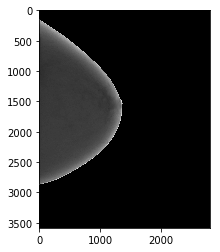

In [31]:
plt.imshow(a, cmap='gray')
#plt.hist(a.flatten())

In [ ]:
# [STAR] For generating the projections

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)




#testvol = ndimage.zoom(testvol, 0.25, order=1)
#testvol = np.zeros([320, 448, 800], dtype='uint8')

scaling_factor = 1

SOD       = 65/0.025
ODD       = 4.5/0.025
detWidth  = 0.0085/0.025 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3200
detCols   = 1600


num_angles = 25

#estimate = np.fromfile("/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/ClinicalExample/CE-05_R/ce.800x448x320.05-le.raw", dtype='float32')
#estimate = np.reshape(estimate, [320, 448, 800])


a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0


vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

print('Starting Recon')


#proj_arr = np.array(proj_arr).astype('float16')
#proj_arr = np.rollaxis(proj_arr, 1, 0)
#proj_arr = proj_arr.flatten()


# All Flags
recon_type       = 0
use_old_calci    = 0 # Use already generated calcifications
save_projections = 1 # Save the projections
insert_noise     = 1


triple_dose  = True
quarter_dose = True
normal_dose  = True

# SIRT iteration LOOP
if recon_type == 0:
    niter      = 10
    start_time = time.time()
    
    for index in range(43, 69):
        print("Phantom ", index)
        a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
        testvol = np.rollaxis(a, 2, 0)
        testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
        volume_mask = testvol > 0
        
        testvol = np.multiply(volume_mask, testvol)
        testvol = testvol/65.0
        
        ang = []
        for i in range(num_angles):
            ang.append(1.9)
        start_angle = -25#+np.random.randint(0, 3)
        theta       = []
        for i in range(num_angles):
            theta.append(start_angle*np.pi/180.0)
            start_angle = start_angle+ang[i]
        
        vectors = np.zeros((len(theta), 12))
        
        # For reconstructing real data
        vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
        vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
        vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
        vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

        # Creating the projection matrix
        proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
        proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
        W                = astra.OpTomo(proj_id)
        
        proj_arr         = W*testvol
        
        temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj = np.rollaxis(temp_proj, 0, 2)
        
        if triple_dose:
            I0        = 6000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)
        
        if normal_dose:
            I0        = 2000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)
        
        if(quarter_dose):
            I0        = 500
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)
        
            #g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            #g_noi[g_noi < 0]        = 0
            #proj_arr = proj_noi#g_noi
        
#         temp_proj  = np.reshape(proj_arr, [detCols, num_angles, detRows])
#         temp_proj1 = temp_proj[:, 15:-15, :]
        
#         # Saving the Projections
#         if save_projections:
#             fid = open('/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[0])+'x'+str(temp_proj.shape[1])+'.'+str(index)+'.raw', 'w')
#             temp_proj  = np.rollaxis(temp_proj, 0, 2)
#             np.array(temp_proj).astype('float32').tofile(fid)
        